# Neural Simulation-Based Inference of the Neutron Star Equation of State directly from Telescope Spectra

This notebook serves as a supplement to our paper [1]. It is meant to provide some working examples so that our published analysis can be reproduced or developed further in future works. Please make sure to install the requirements and download the data as described in the github repository before running this notebook.

We start by loading the simulated data, i.e., the telescope spectra created using XSPEC as well as the corresponding equation of state (EoS) and nuisance parameters. We then illustrate how to train the density estimators to approximate the likelihood of the telescope spectra using these data. Finally, we show how to access and analyze the output of the Hamiltonian Monte Carlo algorithm. 

[1] L. Brandes, C. Modi, A. Ghosh, D. Farrell, L. Lindblom, L. Heinrich, A. W. Steiner, F. Weber, and D. Whiteson, arXiv:2403.00287 (2024).

In [72]:
# import packages

import torch
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rc
import pickle
from tqdm.auto import tqdm
import arviz as az
import time
from sbi.utils.get_nn_models import likelihood_nn
from sbi.inference import SNLE_A 

In [4]:
# set parameters for nice looking plots

rc('font', **{'family':'sans-serif', 'sans-serif':['Helvetica']})
rc('text', usetex=True)

plt.rc('text', usetex=True)
plt.rc('font', family='serif', )

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

Load the telescope spectra `spectra_noisy` simulated with XSPEC including Poisson noise (we use only the first 250 non-vanishing detector channels) and the corresponding EoS and nuisance parameters `theta_spectra`, which are ordered as $[\lambda_1, \lambda_2, N_H, d, \log( T_\mathrm{eff})]$. Note that these must have been downloaded beforehand!

In [2]:
theta_spectra = np.load('./data/theta_spectra.npy')
spectra_noisy = np.load('./data/spectra_noisy.npy')

# convert simulated data to torch tensors
theta_spectra = torch.tensor(theta_spectra, dtype=torch.float32)
spectra_noisy = torch.tensor(spectra_noisy, dtype=torch.float32)

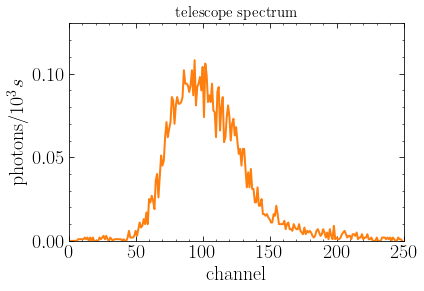

In [77]:
# plot one example simulated telescope spectrum

plt.plot(spectra_noisy[66841] * 1000, lw = 2, c = 'C1')

plt.ylim([0.0,0.13])
plt.xlim([0,250])

plt.title('telescope spectrum', fontsize = 15)
plt.ylabel('photons/$10^3s$', fontsize = 20)
plt.xlabel('channel', fontsize = 20)
plt.tick_params(top = 1 , right = 1, which = 'both', direction = 'in', labelsize = 20)

## Density estimators

In this section we provide an example of the training of the normalizing flows based on the simulated data using the sbi package [2] to implement the neural likelihood estimation (NLE) method. In our analysis, we use Masked Autoregressive Flows (MAFs) [3] which are already implemeneted in sbi. We also illustrate how to load the pre-trained density estimators.

[2]  A. Tejero-Cantero, J. Boelts, M. Deistler, J.-M. Lueckmann, C. Durkan, P. Gon¸calves, D. Greenberg, and J. Macke,
Journal of Open Source Software 5, 2505 (2020). 

[3]  G. Papamakarios, T. Pavlakou, and I. Murray, NeurIPS 30 (2017).

In [76]:
start = time.time()

# hyperparameters of the flow
nblocks = 3
ntransforms = 5
nbatch = 25
lr = 4e-05
nhidden = 56

# build masked autoregressive flow with above specified hyperparameters for training
density_estimator_build_fun = likelihood_nn(model='maf', 
                                            hidden_features=nhidden, 
                                            num_transforms=ntransforms, 
                                            num_blocks=nblocks)
inference = SNLE_A(density_estimator=density_estimator_build_fun)


# append simulated data for training
# note that in our analysis we used only the first 55688 samples for training and validation
# the rest ist left for testing 
inference.append_simulations(theta_spectra[:55688], spectra_noisy[:55688])


# training
# here: limit number of epochs for a fast evaluation, for full training this keyword should be removed
density_estimator = inference.train(training_batch_size=nbatch, 
                                    learning_rate=lr,
                                    show_train_summary=True, 
                                    max_num_epochs=5) 

end = time.time()

print('\nFINISHED TRAINING: in', round(end - start), 'seconds, with parameters [nblocks, ntransforms, nbatch, lr, nhidden] = ', [nblocks, ntransforms, nbatch, round(lr,5), nhidden])

 Training neural network. Epochs trained: 6
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 6
        Best validation performance: 2852.8637
        -------------------------
        

FINISHED TRAINING: in 144 seconds, with parameters [nblocks, ntransforms, nbatch, lr, nhidden] =  [3, 5, 25, 4e-05, 56]


In [14]:
# alternatively, load beforehand trained density estimators
# these were determined from a hyperparameter search using only the top N = 5 best-performing flows

NUM_DENSITY_ESTIMATORS = 5
density_estimators = []
for f in range(1, NUM_DENSITY_ESTIMATORS+1):
    filename = "./data/density_estimator_top" + str(f) + ".pkl"
    with open(filename, "rb") as g:
        density_estimators.append(pickle.load(g))

The density estimators approximate the likelihood of the telescope spectra $s$ given the EoS parameters $\lambda$ and nuisance parameters $\nu$, $p(s|\lambda, \nu)$. For given EoS and nuisance parameters, we can sample telescope spectra from the flows and compare them to a simulated spectrum.

In [33]:
# sample from the top 5 pre-trained flows

# number of samples per flow
num_samples = 1

densest_samples = []
for i in tqdm(range(5)):
        # set EoS and nuisance parameters to a specific value of the previously loaded samples
        densest_samples.append(density_estimators[i].sample(num_samples, theta_spectra[66841:66841+1], None).detach().numpy()) 
densest_samples = np.array(densest_samples)
densest_samples = densest_samples.reshape(num_samples*5, 250)

  0%|          | 0/5 [00:00<?, ?it/s]

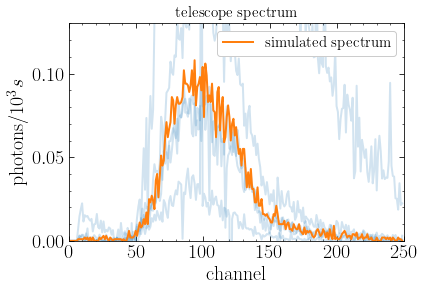

In [82]:
# plot spectra sampled from the density estimators
[plt.plot(d * 1000, lw = 2, c = 'C0', alpha=0.2) for d in densest_samples]

# and compare to the corresponding spectrum simulated with XSPEC 
plt.plot(spectra_noisy[66841] * 1000, lw = 2, c = 'C1', label='simulated spectrum')

plt.ylim([0.0,0.13])
plt.xlim([0,250])

plt.legend(fontsize = 15, framealpha=1.0)
plt.title('telescope spectrum', fontsize = 15)
plt.ylabel('photons/$10^3s$', fontsize = 20)
plt.xlabel('channel', fontsize = 20)
plt.tick_params(top = 1 , right = 1, which = 'both', direction = 'in', labelsize = 20)

Note that the likelihood $p(s|\lambda, \nu)$ is not conditioned on the neutron star mass $M$, but instead marginalizes over all neutron star masses. Consequently, the sampled spectra do not necessarily coincide with the simulated spectrum. See the discussion in [1] on the inclusion of the mass as an additional nuisance parameter.

In [105]:
# compute the log likelihood for given parameters using the density estimators 

# here: take the ground truth parameters of the simulated spectrum 
theta = theta_spectra[66841:66841+1]

# evaluate the log likelihood based on the simulated spectrum 
# average over the density estimators
log_p = 0
for d in density_estimators:
    log_p +=  d.log_prob(spectra_noisy[66841][None], theta).detach()

log_p = log_p[0]/len(density_estimators)

print('The log probability of the parameters', theta[0].numpy(), 'based on the simulated spectrum with index 66841 is', log_p.numpy())

The log probability of the parameters [ 4.885865 -1.879443  1.03556  12.251036  6.185885] based on the simulated spectrum with index 66841 is 3057.2578


# Analyzing HMC results

Finally, in this section we illustrate how to analyze the output of the code `NLE_spectra_HMC_xspec.py` used to generate posterior samples using Hamiltonian Monte Carlo (HMC) methods. For that we have prepared one example output that was generated for the observation index (`OBS_IDX`) 45, that specifies the index of the EoS and nuisance parameters and also the indices of the 10 simulated spectra used as observations (for more details see the corresponding code). The example output consists of 16 HMC chains which ran for 2000 steps each, after initially adapting the step size for 300 steps.   

In [109]:
# load in  the HMC chains, the indices of the simulated spectra used as observations (obs_indices)
# and the nuisance parameter priors (parametrized by t_full)

filename = '_45.npy'
hmc_samples_chains = np.load('./data/tight_hmc_chains'+filename) #20231001193805
obs_indices = np.load('./data/tight_obs_indices'+filename)
t_full = np.load('./data/tight_priors'+filename)

[68346 68348 68374 68358 68332 68351 68308 68399 68398 68404]


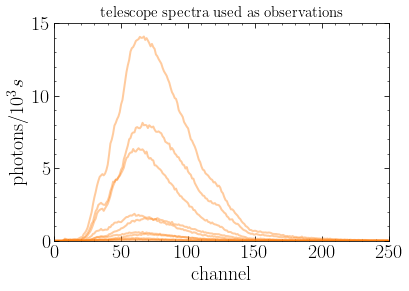

In [139]:
# indices of the 10 simulated spectra used as observations on 

print(obs_indices)

# plot the spectra
[plt.plot(spectra_noisy[i] * 1000, lw = 2, c = 'C1', alpha=0.4) for i in obs_indices]

plt.ylim([0.0,15])
plt.xlim([0,250])

plt.title('telescope spectra used as observations', fontsize = 15)
plt.ylabel('photons/$10^3s$', fontsize = 20)
plt.xlabel('channel', fontsize = 20)
plt.tick_params(top = 1 , right = 1, which = 'both', direction = 'in', labelsize = 20)

In [142]:
# print the corresponding parameters, all spectra share the same EoS parameters
[print(theta_spectra[i].numpy()) for i in obs_indices];

[ 4.9331975 -1.944389   0.025356   4.203314   6.124009 ]
[ 4.9331975 -1.944389   0.017995   8.781524   6.157289 ]
[ 4.9331975 -1.944389   0.129038   7.700947   6.281771 ]
[ 4.9331975 -1.944389   0.052791   4.264069   6.294694 ]
[ 4.9331975 -1.944389   0.013859   2.967181   6.244394 ]
[ 4.9331975 -1.944389   0.276745   3.703901   6.047246 ]
[ 4.9331975 -1.944389   0.01945   10.359227   6.047719 ]
[ 4.9331975 -1.944389   0.055491  10.921337   6.109991 ]
[ 4.9331975 -1.944389   0.030372   2.830106   6.226911 ]
[ 4.9331975 -1.944389   0.114227  11.970157   6.105825 ]


In [143]:
# means of the prior distributions of the nuisance parameters
# there are three nuisance parameters per star, so 30 in total
print(t_full)

[ 0.02054627  4.217557    6.2335196   0.01232921  9.091616    6.0038686
  0.12643494  7.047886    6.258849    0.06403841  4.1506653   6.2649603
  0.01322916  2.6851866   6.2172117   0.23759896  3.8181353   6.0316324
  0.01706674  9.588078    6.0313015   0.0569765  10.909696    6.255736
  0.02088929  2.7981887   6.248334    0.09881237 12.2589      6.0753374 ]


The 10 stars with observed spectra have three nuisance parameters $\nu$ each and share the two equation of state parameters $\lambda$. Here, we display the HMC chains for one of the 32 parameters.

rhat value: 1.0004659564867953
estimate of the effective sample size: 14555.518395355277


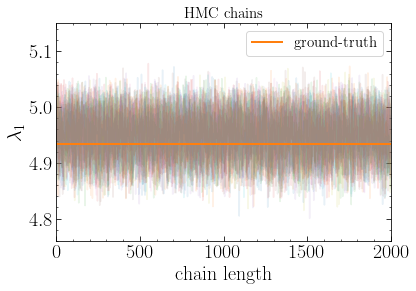

In [113]:
# specify the parameter to display, e.g., zero corresponds to the first EoS parameter
idx = 0

# create the full 32 dimensional parameter vector with EoS and nuisance parameters 
theta_full = torch.cat([theta_spectra[obs_indices[0]][:2], theta_spectra[obs_indices][:,2:].flatten()]).numpy()

# plot all 2000 steps for each HMC chain, each color corresponds to a different chain
plt.plot(hmc_samples_chains[:,:,idx].T, alpha=0.1)

# plot underlying ground-truth value for the parameter as a constant line
plt.axhline(theta_full[idx], color='C1', lw=2, label='ground-truth')

# common metrics to access the convergence of MCMC are the rhat value and the effective sample size
# print them here for the specified parameter
print('rhat value:', az.rhat(hmc_samples_chains[:,:,idx]))
print('estimate of the effective sample size:', az.ess(hmc_samples_chains[:,:,idx]))

plt.title('HMC chains', fontsize = 15)
plt.ylabel('$\lambda_1$', fontsize = 20)
plt.xlabel('chain length', fontsize = 20)
plt.legend(fontsize = 15)
plt.xlim([0, 2000])
plt.ylim([4.76, 5.15])
plt.tick_params(top = 1 , right = 1, which = 'both', direction = 'in', labelsize = 20)

The chains look well converged, which is verified by the rhat value close to one. If some of the chains have not converged due to a wrong hyperparameter choice in the HMC algorithm, one might need to delete them. One possible metric to check for such missing convergence of individual chains is to check whether removing the chain decreases the total rhat value.

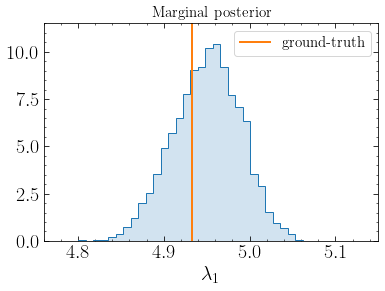

In [115]:
# plot the 1D posterior distributions 
idx = 0

# we take only every 10th step of every chain
# they are combined to one posterior sample
_ = plt.hist(hmc_samples_chains[:,:,idx].flatten()[::10], bins=30, density=True, color='C0', alpha=0.2, histtype='stepfilled')
_ = plt.hist(hmc_samples_chains[:,:,idx].flatten()[::10], bins=30, density=True, edgecolor='C0', histtype='step')

# plot ground-truth value as a constant line
plt.axvline(theta_full[idx], color='C1', lw=2, label='ground-truth')

plt.title('Marginal posterior', fontsize = 15)
plt.xlabel('$\lambda_1$', fontsize = 20)
plt.legend(fontsize = 15)
plt.xlim([4.76, 5.15])
plt.ylim([0, 11.5])
plt.tick_params(top = 1 , right = 1, which = 'both', direction = 'in', labelsize = 20)

In [124]:
# evaluate maximum-a-posterior (MAP) estimates of the marginal posteriors for the EoS parameters to the ground-truth values
map_diffs = []

for idx in range(2):

    # histogram of the marginal posterior distribution
    hist, bins = np.histogram(hmc_samples_chains[:,:,idx].flatten()[::10], bins=50, density=True)

    # Find the bin with the maximum probability (mode)
    bin_with_max_prob = np.argmax(hist)

    # Compute the MAP estimate as the midpoint of the bin with the maximum probability
    map_estimate = (bins[bin_with_max_prob] + bins[bin_with_max_prob + 1]) / 2

    map_diffs.append(map_estimate - theta_full[idx])
    
print('\lambda_1,pred -  \lambda_1,true \t', map_diffs[0])
print('\lambda_2,pred -  \lambda_2,true \t', map_diffs[1])

\lambda_1,pred -  \lambda_1,true 	 0.02150593099947873
\lambda_2,pred -  \lambda_2,true 	 -0.03508072987578337
